In [12]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
table = read_csv('/content/drive/MyDrive/NNdata.csv')
#table = read_csv('/content/drive/MyDrive/Thesis/csvs/NNdata.csv')
table.head()

,Date,IDStation,NameStation,Ammonia,Arsenic,Benzene,Benzo_a_pyrene,Cadmium,CO,Lead,Nikel,NO,NO2,NOx,Ozone,PM10,PM25,Sulfur_dioxide,IDStation.1,reg_Y_nn1_ID,Date.1,IDStation.2,NameStation.1,Wind_speed,Wind_direction,Temperature,Relative_humidity,Global_radiation,Wind_speed_max,Wind_direction_max,Rainfall
0,2018-01-01T00:00:00Z,677,Cremona Via Fatebenefratelli,6.2,NaN,NaN,NaN,NaN,0.508333,NaN,NaN,NaN,36.175000,63.570833,5.225000,NaN,45.0,1.829167,677,677,2018-01-01T00:00:00Z,677,Cremona Via Fatebenefratelli,0.483454,314.0,2.615278,93.738194,21.268056,2.133333,NaN,7.2
1,2018-01-01T00:00:00Z,681,Moggio,1.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.341667,3.308333,5.075000,66.100000,5.0,4.0,NaN,681,111,2018-01-01T00:00:00Z,111,Cassina Valsassina Moggio,0.300970,65.0,2.095833,74.055556,60.152778,1.939583,144.0,2.4
2,2018-01-01T00:00:00Z,703,Schivenoglia,NaN,NaN,1.0,NaN,NaN,1.159091,NaN,NaN,NaN,25.572727,35.850000,9.281818,44.0,43.0,4.813636,703,671,2018-01-01T00:00:00Z,671,Mantova Tridolino,1.540787,288.0,2.761806,99.475694,14.163194,3.524306,NaN,5.8
3,2018-01-02T00:00:00Z,677,Cremona Via Fatebenefratelli,1.8,NaN,NaN,NaN,NaN,0.375000,NaN,NaN,NaN,35.925000,47.750000,18.441667,32.0,27.0,1.341667,677,677,2018-01-02T00:00:00Z,677,Cremona Via Fatebenefratelli,1.788399,284.0,5.974306,70.609722,72.734028,4.377083,NaN,0.0
4,2018-01-02T00:00:00Z,681,Moggio,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.441667,1.283333,85.891667,3.0,2.0,NaN,681,111,2018-01-02T00:00:00Z,111,Cassina Valsassina Moggio,0.613183,9.0,1.670139,39.194444,68.250000,3.075000,213.0,0.0


In [15]:
Moggio = table.loc[table.loc[:,"NameStation"]=="Schivenoglia",:]
Moggio = Moggio.loc[:,["Date","Ammonia","PM10","PM25","Wind_speed","Wind_direction","Temperature","Rainfall"]]
Moggio = Moggio.dropna(how="any") #Cancella su tutta la riga anche solo con un mancante
Moggio = Moggio.reset_index()
Moggio = Moggio.iloc[:730,:] # we train not using 2020, for now
Moggio.head()


,index,Date,Ammonia,PM10,PM25,Wind_speed,Wind_direction,Temperature,Rainfall
0,8,2018-01-03T00:00:00Z,16.2,39.0,38.0,0.455321,350.0,2.511111,0.0
1,11,2018-01-04T00:00:00Z,17.1,44.0,37.0,0.169860,86.0,5.018056,0.0
2,14,2018-01-05T00:00:00Z,20.5,40.0,39.0,0.349338,268.0,4.311806,0.0
3,17,2018-01-06T00:00:00Z,28.5,86.0,82.0,0.302877,323.0,7.853472,0.0
4,20,2018-01-07T00:00:00Z,21.8,43.0,33.0,1.881774,81.0,9.195139,0.0


##Convert series to supervised learning

###Conversion Function

In [16]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

### Conversion of Moggio

In [11]:
values = Moggio.iloc[:,2:].values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_days = 5
reframed = series_to_supervised(scaled, n_days, 1) # info of the past 5 days to determine next (1) day
# drop columns we don't want to predict (we therefore keep Ammonia)
reframed.drop(reframed.columns[[36,37,38,39,40,41]], axis=1, inplace=True)

reframed.head()
reframed.shape

(652, 36)

In [8]:
# split into train and test sets
values = reframed.values
n_features = 7 # number of variables, including the one to be predicted
n_train_days = 365 # we train using only the first year
train = values[:n_train_days, :]
test = values[n_train_days:, :] # we test using all successive years 
# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(365, 35) 365 (365,)
(365, 5, 7) (365,) (287, 5, 7) (287,)


# Modeling and training

Epoch 1/200
8/8 - 9s - loss: 0.0356 - val_loss: 0.0224 - 9s/epoch - 1s/step
Epoch 2/200
8/8 - 0s - loss: 0.0247 - val_loss: 0.0173 - 137ms/epoch - 17ms/step
Epoch 3/200
8/8 - 0s - loss: 0.0238 - val_loss: 0.0232 - 139ms/epoch - 17ms/step
Epoch 4/200
8/8 - 0s - loss: 0.0220 - val_loss: 0.0175 - 127ms/epoch - 16ms/step
Epoch 5/200
8/8 - 0s - loss: 0.0230 - val_loss: 0.0192 - 122ms/epoch - 15ms/step
Epoch 6/200
8/8 - 0s - loss: 0.0222 - val_loss: 0.0194 - 121ms/epoch - 15ms/step
Epoch 7/200
8/8 - 0s - loss: 0.0219 - val_loss: 0.0182 - 130ms/epoch - 16ms/step
Epoch 8/200
8/8 - 0s - loss: 0.0222 - val_loss: 0.0191 - 123ms/epoch - 15ms/step
Epoch 9/200
8/8 - 0s - loss: 0.0218 - val_loss: 0.0184 - 131ms/epoch - 16ms/step
Epoch 10/200
8/8 - 0s - loss: 0.0220 - val_loss: 0.0184 - 129ms/epoch - 16ms/step
Epoch 11/200
8/8 - 0s - loss: 0.0218 - val_loss: 0.0187 - 122ms/epoch - 15ms/step
Epoch 12/200
8/8 - 0s - loss: 0.0216 - val_loss: 0.0180 - 128ms/epoch - 16ms/step
Epoch 13/200
8/8 - 0s - loss: 

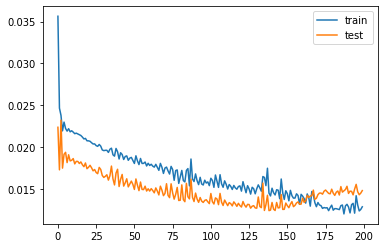

In [10]:
# design network
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
early_stopping = EarlyStopping(patience=10, restore_best_weights = True)
history = model.fit(train_X, train_y, epochs=200, batch_size=50, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=early_stopping)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Predictions 

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.571


In [ ]:
# make a prediction using 2020 (not used for training or validation, and has different dynamics due to covid)
# adding back the data from 2020
Moggio = table.loc[table.loc[:,"NameStation"]=="Moggio",:]
Moggio = Moggio.loc[:,["Date","Ammonia","PM10","PM25","Wind_speed","Wind_direction","Temperature","Rainfall"]]
Moggio = Moggio.dropna(how="any")
Moggio = Moggio.reset_index()
#scaling and creating the new testing data
values = Moggio.iloc[:,2:].values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_days = 5
reframed = series_to_supervised(scaled, n_days, 1) # info of the past 5 days to determine next (1) day
# drop columns we don't want to predict (we therefore keep Ammonia)
reframed.drop(reframed.columns[[36,37,38,39,40,41]], axis=1, inplace=True)
# split into train and test sets
values = reframed.values
n_features = 7 # number of variables, including the one to be predicted
n_train_days = 365 # we train using only the first year
train = values[:n_train_days, :]
test = values[n_train_days:, :] # we test using all successive years 
# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(365, 35) 365 (365,)
(365, 5, 7) (365,) (568, 5, 7) (568,)


In [ ]:
# predicting: make a prediction using 2019 and 2020 (not used for training or validation, and has different dynamics due to covid)
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.571


#### Prediciton plots

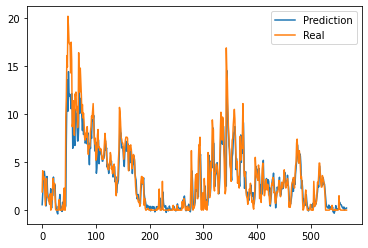

In [ ]:
pyplot.plot(inv_yhat, label = 'Prediction')
pyplot.plot(inv_y, label = 'Real')
pyplot.legend()
pyplot.show()
#print(inv_y)

# Modeling with hyperparamenter search

In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 2.7 MB/s 


In [ ]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

In [ ]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
def model_builder(hp):
  # design network
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model = Sequential()
  model.add(LSTM(units = hp_units,return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
  for i in range(hp.Int('layers',1,3)):
   model.add(LSTM(units = hp_units, return_sequences=True))
  model.add(LSTM(units = hp_units, return_sequences=False))
  model.add(Dense(1))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate))
  return model

In [ ]:
def model_builder(hp):
  # design network
  hp_units = hp.Int('units', min_value=10, max_value=100, step=25)
  model = Sequential()
  model.add(LSTM(units = hp_units,return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
  for i in range(hp.Int('layers',0,1)):
   model.add(LSTM(units = hp_units, return_sequences=True))
  model.add(LSTM(units = hp_units, return_sequences=False))
  model.add(Dense(1))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate))
  return model

In [ ]:
tuner = kt.RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=10,
    executions_per_trial =3,
    directory = 'dir',
    project_name = 'namee')
tuner.search_space_summary()

Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 25, 'sampling': None}
layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 1, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',patience=10)
tuner.search(train_X, train_y, epochs=100, batch_size=100, validation_data=(test_X, test_y),shuffle=False, callbacks=[early_stopping])


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
units             |85                |?                 
layers            |1                 |?                 
learning_rate     |0.0001            |?                 

Epoch 1/100
3/4 [=====================>........] - ETA: 0s - loss: 0.2601 

ValueError: ignored

In [ ]:
tuner.results_summary()

### Hyperband

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

In [ ]:
tuner.search(train_X, train_y, epochs=1000, batch_size=72, validation_data=(test_X, test_y),shuffle=False, callbacks=[early_stopping])